# Moravec角点检测算子和Harris角点检测算子

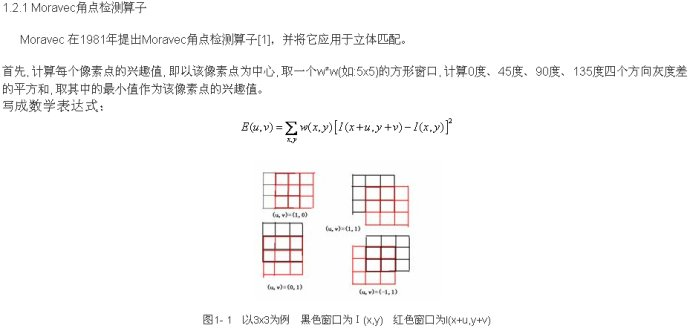

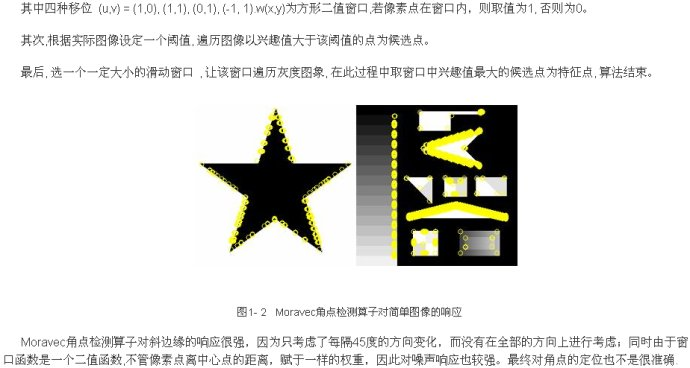

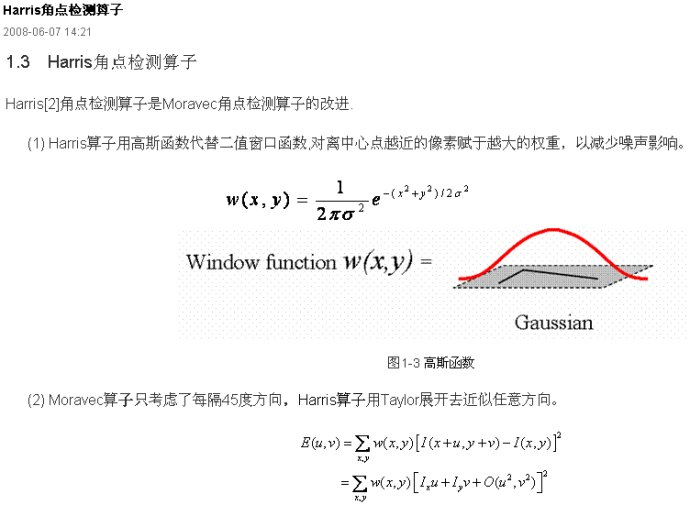

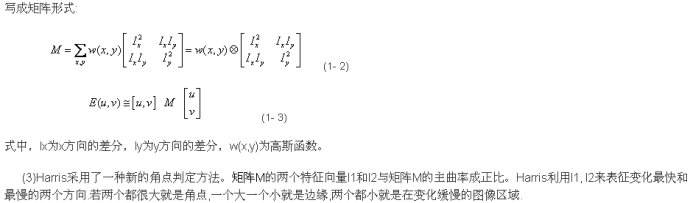

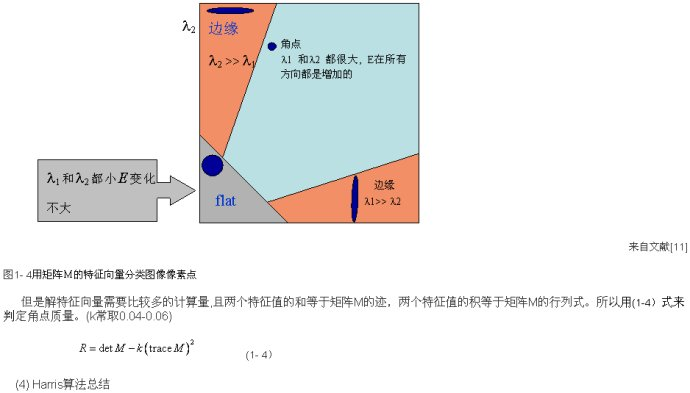

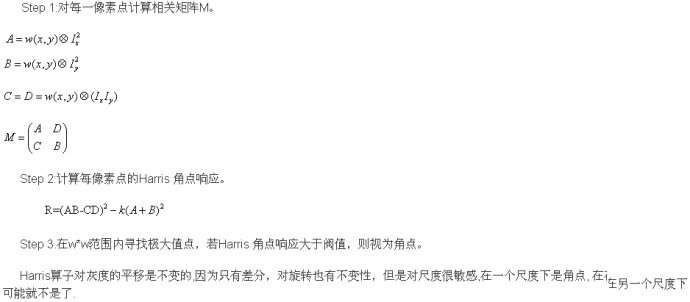

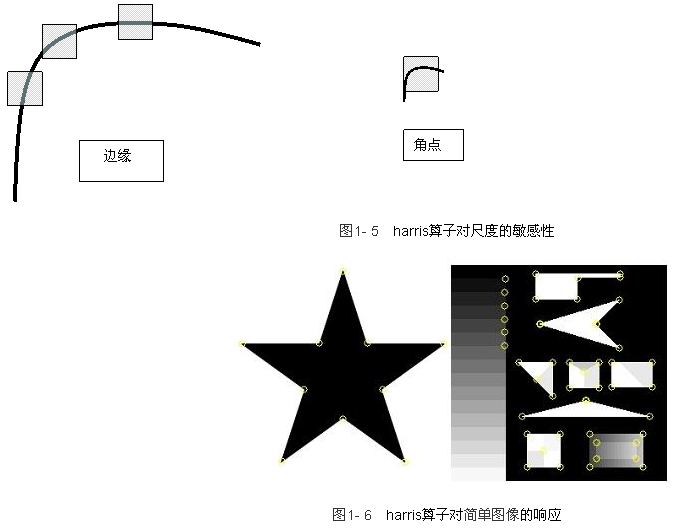

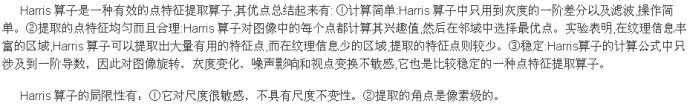

参考：

[1]. http://blog.sina.com.cn/s/blog_4bdb170b0100qqg0.html

(1)首先我们来看三幅图片理解什么是角点：
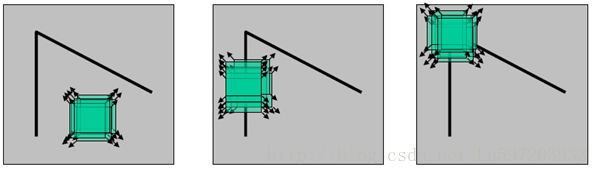
我们在图片以某像素点为中心，取一窗口，当窗口向各个方向移动时，其内部灰度值变化不是很明显，则该点即处在平坦区域(如左边图)；当其内部灰度值只在几个固定的方向上变化较为明显，那么该点则处在边缘区域(如图中间部分)；当向各个方向移动，其变化都是很明显，则该点为角点(如图右)。

当然，上面所说的变化明显与否，是与我们事先设定的阀值进行对比的。

(2)moravec算法对角点定义：

窗口在各个方向上移动，窗口内的灰度值都会产生较大的变化。但实际程序中，这里的各个方向实际只有8个方向。即米形0°，45°，90°，135°，180°，225°，270°，315°。

例如：

这里我们为了简单起见，我们只取了四个方向(0°，45°，90°，135°)，取一个w*w(如:5x5)的方形窗口, 计算0度、45度、90度、135度四个方向灰度差的平方和, 取其中的最小值作为该像素点的兴趣值(如下图)。

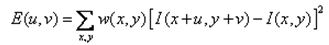

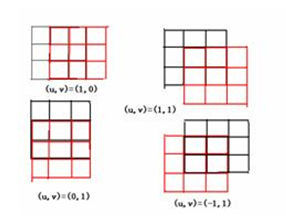

moravec角点检测实现：

步骤：

1. 对于每一个像素点，计算在E(u,v),在我们的算法中，(u,v)的取值是((1,0), (1,1), (0,1), (-1, 1),这里只取了四个方向
2. 计算最小值对应的每个位置minValue = min{E(u,v)}
3. 对每个位置minValue进行判定，是不是大于设定的阀值，其中还有个过程是判断其是否为局部最大值以防止产生重复的角点

参考：

[1]. https://blog.csdn.net/qq_20823641/article/details/52275543

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import cv2
import numpy as np
import skimage
import skimage.io
import imageio
import math
import scipy
from scipy import ndimage
from scipy import misc

In [17]:
src = imageio.imread('../datas/building_2.jpg')
gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)

In [13]:
def moravec_conner(src,ksize,thresh):
    gray = src
    if len(src.shape) > 2:
        gray = cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)
    gray = np.float32(gray)
    rows,cols = gray.shape
    dst = np.zeros((rows,cols,3),dtype=gray.dtype)
    dst[:,:,0] = gray
    dst[:,:,1] = gray
    dst[:,:,2] = gray
    points = []
    r = ksize // 2
    for i in range(r,rows - r):
        for j in range(r,cols - r):
            v1,v2,v3,v4 = 0.,0.,0.,0.
            # 水平方向
            for k in range(-r,r):                
                v1 += gray[i,j+k] - (gray[i,j+k+1] * gray[i,j+k])-gray[i,j+k+1]
            # 垂直方向
#             for k in range(-r,r):
                v2 += gray[i+k,j] - gray[i+k+1,j] * gray[i+k,j] - gray[i+k+1,j]
        
            # 45度方向
#             for k in range(-r,r):
                v3 += gray[i+k,j+k] - gray[i+k+1,j+k+1] * gray[i+k,j+k] - gray[i+k+1,j+k+1]
            # 135度方向
#             for k in range(-r,r):
                v4 += gray[i+k,j-k] - gray[i+k+1,j-k-1] * gray[i+k,j-k] - gray[i+k+1,j+k+1]
            value = np.min([v1,v2,v3,v4])
            if value > thresh:
                points.append((j,i))
    # 绘制角点
    for i in range(len(points)):
        cv2.circle(dst,points[i],5,(255,0,0))
    return dst,points

In [ ]:
dst,points = moravec_conner(gray,5,120)

In [ ]:
plt.imshow(dst)

In [18]:
def moravec_window(a, y, x, u, v):
    a1 = (int(a[y + u + 1, x + v - 1]) - int(a[y + 1, x - 1]))**2
    a2 = (int(a[y + u + 0, x + v - 1]) - int(a[y + 0, x - 1]))**2
    a3 = (int(a[y + u - 1, x + v - 1]) - int(a[y - 1, x - 1]))**2
    a4 = (int(a[y + u - 1, x + v + 0]) - int(a[y - 1, x + 0]))**2
    a5 = (int(a[y + u - 1, x + v + 1]) - int(a[y - 1, x + 1]))**2
    a6 = (int(a[y + u + 0, x + v + 1]) - int(a[y + 0, x + 1]))**2
    a7 = (int(a[y + u + 1, x + v + 1]) - int(a[y + 1, x + 1]))**2
    a8 = (int(a[y + u + 1, x + v + 0]) - int(a[y + 1, x + 0]))**2
    amid = (int(a[y + u + 0, x + v + 0]) - int(a[y + 0, x - 0]))**2
    res = a1 + a2 + a3 + a4 + a5 + a6 + a7 + a8+ amid
    return(res)

In [19]:
def moravec(I):
    """
    Input : name of image
    Output: interest points
    """
#     I = cv2.imread(Iname)
    I_bw = ndimage.filters.gaussian_filter(I.astype(float), 4.52)
    I_bw = misc.imresize(I_bw, 25, 'bilinear').astype(float)
    I = np.array(I_bw)
    dst = I.copy()
    cornerness = []
    corners = []

    for y in range(3, len(I_bw) - 3):
        for x in range(3, len(I_bw[0]) - 3):
            m1 = moravec_window(I_bw, y, x, 1, -1)
            m2 = moravec_window(I_bw, y, x, 0, -1)
            m3 = moravec_window(I_bw, y, x, -1, -1)
            m4 = moravec_window(I_bw, y, x, -1, 0)
            m5 = moravec_window(I_bw, y, x, -1, 1)
            m6 = moravec_window(I_bw, y, x, 0, 1)
            m7 = moravec_window(I_bw, y, x, 1, 1)
            m8 = moravec_window(I_bw, y, x, 1, 0)
            cornerness.append([y, x, min(m1, m2, m3, m4, m5, m6, m7, m8)])

    for cornerlen in range(0, len(cornerness)):
        #print(cornerness[cornerlen][2])
        if (cornerness[cornerlen][2] > 1900):
            y = cornerness[cornerlen][0]
            x = cornerness[cornerlen][1]
            cv2.circle(dst, (x, y), 3, 4, 2)
            corners.append([y, x, 11])
    corners = np.array(corners)
    return np.uint8(dst),corners
#     np.save(Iname[:-4], corners)
#     print("# points found ", len(corners))

c:\programdata\anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  


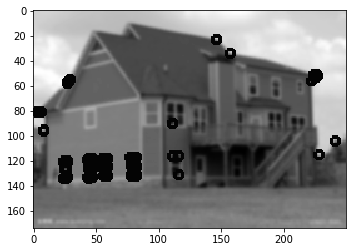

In [20]:
dst,conners = moravec(gray)
plt.imshow(dst,'gray')